# Usage of the Event Detector by Jorde and Jacobsen

# Load the required packages

In [9]:
# Import public packages
import sys
import os
from pathlib import Path
import ipdb
from matplotlib import pyplot as plt
import glob
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from io import StringIO
from tensorflow.keras.backend import clear_session
# Add src to the path for import
project_dir = Path(os.getcwd()).resolve().parents[0]
module_path = os.path.abspath(os.path.join(project_dir))  
if module_path not in sys.path:
    sys.path.append(module_path)

# Import private source code
from Event_Detectors import EventDet_MEED

# Activate Autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set all global Parameters for the BLUED Dataset

In [11]:
# Hardcoded Hyperparameters
DATASET_LOCATION_BLUED = os.path.join("./Test_Data/") #Path to Test Data
TEST_MODEL_PATH = os.path.join("./BLUED_MEED_Test_Model/MEED_Test_Model")
DATASET = "blued_events" #name of the dataset (used to load the file later with my Utility class)
CURRENT_COLUMN = "Current B" # Dataset has two phases: phase A and B. They can be treated independently. We load only Phase B.
NETWORK_FREQUENCY_BLUED = 60 # Base electrical network frequency of the region where the dataset was recorded
SAMPLES_PER_SECOND_BLUED = NETWORK_FREQUENCY_BLUED # We compute two features (data points) per second.
SAMPLERATE_BLUED = 12000 # Sampling Rate the raw BLUED Dataset was recorded with 
WINDOW_SIZE_SECONDS = 10
window_size_samples = WINDOW_SIZE_SECONDS * SAMPLERATE_BLUED
# Compute the period size of the BLUED dataset: i.e. number of raw data points per period
BLUED_period = int(SAMPLERATE_BLUED / NETWORK_FREQUENCY_BLUED) 

# Load and display the BLUED Test File

In [12]:
def load_file_BLUED(file_path, phase="b"):
    """
    Function to load the BLUED test data.
     Args:
            file_path (Path): full path to the test file
            phase (string): either "all", "b" or "a". Returns only the requested phase of the dataset.

    Returns:
            data_df (pandas DataFrame): original columns if phase=="all" else colums are just "Current" and "Voltage" --> already for the matching phase! (* - 1 done for B)
            file_info (dict): dictionary with information about the file that was loaded. Parsed from the filename
            and the metadata included in the file.
    """
    with open(file_path, 'r') as f:

            data_txt = f.read()

            lines = data_txt.splitlines()

            data_txt = data_txt.split("***End_of_Header***")
            reference_time = data_txt[0].split("Date,")[1][:11].replace("\n","") +"-"+ data_txt[0].split("Time,")[1][:15]
            reference_time = datetime.strptime(reference_time, '%Y/%m/%d-%H:%M:%S.%f')


            data_time_str = data_txt[1].split("Time,")[1]
            data_time_str = data_time_str.split(',')

            data_day_str = data_txt[1].split("Date,")[1]
            data_day_str = data_day_str.split(',')

            day_str = data_day_str[0]  # just the first on is enoguh
            time_str = data_time_str[0][:15]  # same for time
            date = day_str + "-" + time_str
            start_date_time = datetime.strptime(date, '%Y/%m/%d-%H:%M:%S.%f')

            filename = Path(file_path).name  # get the file name

            samples = data_txt[1].split("Samples,")[1].split(",")[0:3][0]
            samples = int(samples)

            values_str = data_txt[-1]
            values_str = values_str[values_str.index("X_Value"):]

            measurement_steps = data_txt[1].split("Delta_X")[1].split(",")[0:3]
            measurement_steps = [float(x) for x in measurement_steps if x != ""]
            measurement_steps = measurement_steps[0]

            data_df = pd.read_csv(StringIO(values_str), usecols=["X_Value", "Current A", "Current B", "VoltageA"])

            data_df.dropna(inplace=True,how="any")
           
            file_duration = data_df.tail(1)["X_Value"].values[0]
            file_duration = float(file_duration)

            file_duration = timedelta(seconds=file_duration)
            end_date_time = reference_time + file_duration

            file_duration = end_date_time - start_date_time

            # Convert totimestamps
            data_df["TimeStamp"] = data_df["X_Value"].apply(lambda x: timedelta(seconds=x) + reference_time)
            data_df.drop(columns=["X_Value"],inplace=True)
            data_df.set_index("TimeStamp",inplace=True)

            file_info = {"Filepath": file_path, "Filename": filename, "samples": samples,
                         "file_start": start_date_time, "file_duration": file_duration, "file_end": end_date_time,
                         "measurement_steps": measurement_steps,"reference_time":reference_time}

            if phase.lower() != "all":
                if phase.lower() == "a":
                    data_df["Current"] = data_df["Current A"]
                    data_df["Voltage"] = data_df["VoltageA"]
                elif phase.lower() == "b":
                    data_df["Current"] = data_df["Current B"]
                    data_df["Voltage"] = data_df["VoltageA"].values * -1
                else:
                    raise ValueError("The phase provided does not exist")

                data_df.drop(columns=['Current A', 'Current B',"VoltageA"],inplace=True)

    return data_df, file_info

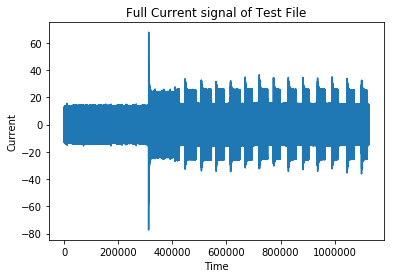

In [13]:
# Get the Test File
test_file = glob.glob(os.path.join(DATASET_LOCATION_BLUED, "*.txt"))[0] #get the full path of the test file

# Load the Data from the test File
data,file_info = load_file_BLUED(test_file)

current = data["Current"].values
voltage = data["Voltage"].values

# Plot the data from the test File
plt.title("Full Current signal of Test File")
plt.ylabel("Current")
plt.xlabel("Time")
plt.plot(current)
plt.show()


# Run the Event Detection on the Test Data

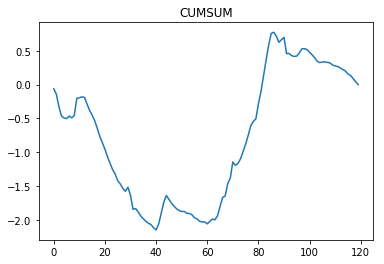

Event Detected at []
+++++++++++++++++++++++++++++++++++


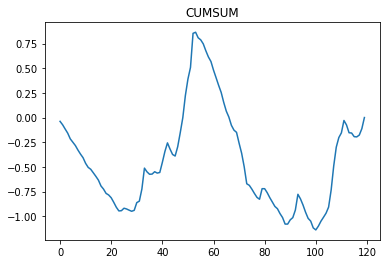

Event Detected at []
+++++++++++++++++++++++++++++++++++


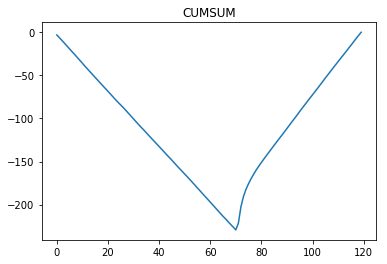

Event Detected at [datetime.datetime(2011, 10, 23, 20, 35, 41, 690166)]
+++++++++++++++++++++++++++++++++++


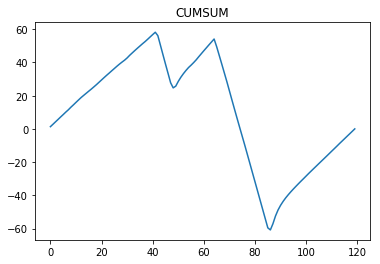

Event Detected at [datetime.datetime(2011, 10, 23, 20, 35, 49, 273499)
 datetime.datetime(2011, 10, 23, 20, 35, 49, 856832)
 datetime.datetime(2011, 10, 23, 20, 35, 51, 190166)
 datetime.datetime(2011, 10, 23, 20, 35, 53, 23499)]
+++++++++++++++++++++++++++++++++++


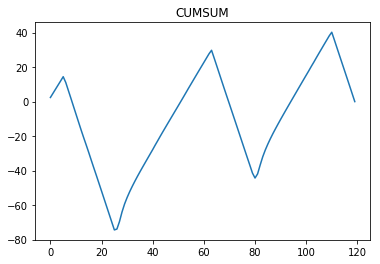

Event Detected at [datetime.datetime(2011, 10, 23, 20, 35, 56, 273499)
 datetime.datetime(2011, 10, 23, 20, 35, 57, 940166)
 datetime.datetime(2011, 10, 23, 20, 36, 1, 106832)
 datetime.datetime(2011, 10, 23, 20, 36, 2, 523499)
 datetime.datetime(2011, 10, 23, 20, 36, 5, 23499)]
+++++++++++++++++++++++++++++++++++


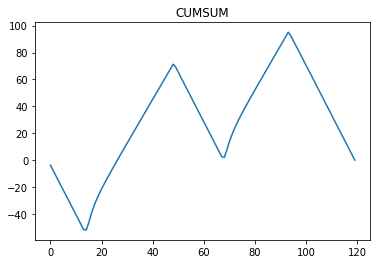

Event Detected at [datetime.datetime(2011, 10, 23, 20, 36, 7, 23499)
 datetime.datetime(2011, 10, 23, 20, 36, 9, 856832)
 datetime.datetime(2011, 10, 23, 20, 36, 11, 523499)
 datetime.datetime(2011, 10, 23, 20, 36, 13, 606832)]
+++++++++++++++++++++++++++++++++++


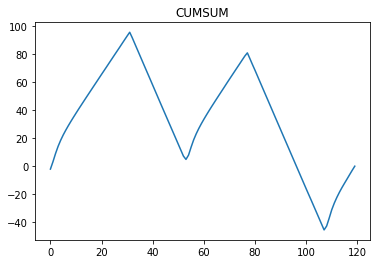

Event Detected at [datetime.datetime(2011, 10, 23, 20, 36, 15, 856832)
 datetime.datetime(2011, 10, 23, 20, 36, 18, 440166)
 datetime.datetime(2011, 10, 23, 20, 36, 20, 273499)
 datetime.datetime(2011, 10, 23, 20, 36, 22, 273499)
 datetime.datetime(2011, 10, 23, 20, 36, 24, 773499)]
+++++++++++++++++++++++++++++++++++


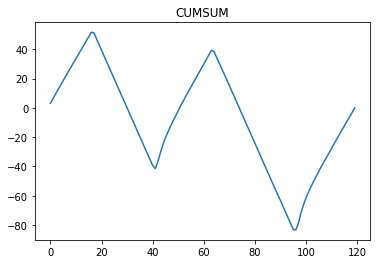

Event Detected at [datetime.datetime(2011, 10, 23, 20, 36, 27, 190166)
 datetime.datetime(2011, 10, 23, 20, 36, 29, 273499)
 datetime.datetime(2011, 10, 23, 20, 36, 31, 106832)
 datetime.datetime(2011, 10, 23, 20, 36, 33, 773499)]
+++++++++++++++++++++++++++++++++++


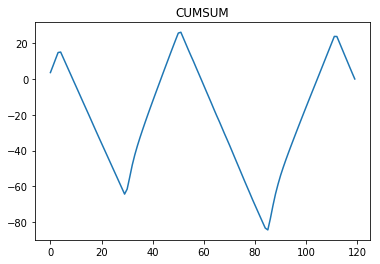

Event Detected at [datetime.datetime(2011, 10, 23, 20, 36, 36, 190166)
 datetime.datetime(2011, 10, 23, 20, 36, 38, 273499)
 datetime.datetime(2011, 10, 23, 20, 36, 40, 106832)
 datetime.datetime(2011, 10, 23, 20, 36, 42, 940166)
 datetime.datetime(2011, 10, 23, 20, 36, 45, 106832)]
+++++++++++++++++++++++++++++++++++


In [14]:
# Step 1: Initialize  the Event Detector
# We hand over an already developed model to algorithm
# The other case, where such a model is not existent is shown below in this notebook
MEED = EventDet_MEED(model_location_p=TEST_MODEL_PATH, coarse_mse_threshold_p=2, signal_length_p=120, network_frequency_p=NETWORK_FREQUENCY_BLUED)

# Step 2: Fit the event detector on some portions of the data
MEED.fit()

samples_remaining = len(current) # number of samples that we have not predicted yet
window_start = 0 # offset of the next window
window_start_timestamp = file_info["file_start"] 

while samples_remaining >= window_size_samples: #while we still have samples to "stream" do the following
    
    window_stop = int(window_start + window_size_samples) # compute end index of the new window
    window_end_timestamp = window_start_timestamp + timedelta(seconds=WINDOW_SIZE_SECONDS)
    
    # Get the voltage and current windows
    voltage_window = voltage[window_start:window_stop]
    current_window = current[window_start:window_stop]

    # Step 3: Use the feature computation function of the algorithm to compute the input features
    window_cumsum, window_rms = MEED.compute_input_signal(current_p=current_window, period_length_p=BLUED_period)

    plt.title("CUMSUM")
    plt.plot(window_cumsum)
    plt.show()
    
    # Step 4: Run the prediciton on the features
    events = MEED.predict(current_cumsum_p=window_cumsum, current_rms_p=window_rms, start_datetime_p=window_start_timestamp,use_median_p=False, cpu_only_p=True)

    if events is not None: # if an event is returned

        print("Event Detected at " + str(events))


    # We start at the end of the previous window
    window_start = int(window_stop)
    window_start_timestamp = window_end_timestamp
  
    print("+++++++++++++++++++++++++++++++++++")
    
    # We need to update the data points that remain for streaming now.
    samples_remaining = samples_remaining - window_size_samples

# In case no MEED model has been trained before

In [15]:
clear_session() # to make the example run we have to clear the tensorflow sesssion first

#Step 1: Initialize  the Event Detector
# We hand over an already developed model to algorithm
# The other case, where such a model is not existent is shown below in this notebook
MEED = EventDet_MEED(model_location_p=TEST_MODEL_PATH, coarse_mse_threshold_p=2, signal_length_p=120, network_frequency_p=NETWORK_FREQUENCY_BLUED)

# Step 2: Fit the event detector on some portions of the data
MEED.fit(train_new_model_p=True)
keras_compiled_model = MEED.model
keras_compiled_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 120, 432)          376704    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 120, 216)          467424    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 120, 432)          748224    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 120, 1)            433       
Total params: 1,592,785
Trainable params: 1,592,785
Non-trainable params: 0
_________________________________________________________________
